# Feature Selection
<hr style="height:1px;border:none;color:#333;background-color:#333;" />


### Basic Configuration

#### Importing Modules

In [198]:
# import modules
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import math
import statsmodels as st
from scipy import stats

import statsmodels.api as sm
import statsmodels.formula.api as smf

import warnings
warnings.filterwarnings("ignore")

from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix
from sklearn.feature_selection import SelectKBest, chi2, SelectFromModel, f_classif, mutual_info_classif, mutual_info_regression
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, MinMaxScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression, LinearRegression, Lasso, LassoCV

#### Dataframes Display Settings

In [140]:
pd.set_option('display.max_columns', None) # display all the columns of a dataframe
pd.set_option('display.max_rows', 100)     # display 100 rows of a dataframe

#### Load data

In [118]:
# Load cleaned data - see "Data Cleansing.ipynb"
dataset = pd.read_csv('../ariel/Price_Data_cleaned.csv')

<hr style="height:1px;border:none;color:#333;background-color:#333;" />

### Exploratory Data Analysis

#### Grouping Variables by Type

In [119]:
continuous_variables = ['GrLivArea', 'LotArea', 'MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF', 
                       'TotalBsmtSF', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF', 'GarageArea', 'WoodDeckSF',
                       'OpenPorchSF', 'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea', 'MiscVal',
                       'SalePrice', 'LotFrontage']

discrete_variables = ['YearBuilt', 'YearRemodAdd', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath',
                      'BedroomAbvGr', 'KitchenAbvGr', 'TotRmsAbvGrd', 'Fireplaces', 'GarageYrBlt', 'GarageCars',
                      'MoSold', 'YrSold']

nominal_variables = ['MSSubClass', 'Alley', 'LandContour', 'MSZoning', 'LotConfig', 'Neighborhood',
                     'Condition1', 'Condition2', 'BldgType', 'HouseStyle', 'RoofStyle', 'RoofMatl',
                     'Exterior1st', 'Exterior2nd', 'MasVnrType', 'Foundation', 'Street', 'Heating',
                     'GarageType', 'CentralAir', 'MiscFeature', 'SaleType', 'SaleCondition']

ordinal_variables = ['OverallQual', 'OverallCond', 'ExterQual', 'ExterCond', 'BsmtQual', 'BsmtCond',
                     'HeatingQC', 'KitchenQual', 'FireplaceQu', 'GarageQual', 'GarageCond', 'PoolQC',
                     'GarageFinish', 'PavedDrive', 'Fence', 'Functional', 'BsmtFinType2', 'Electrical',
                     'BsmtFinType1','BsmtExposure', 'LandSlope', 'Utilities', 'LotShape',]


#### Remove Abnormal Sales
<br>
Only include sales that were completed under 'normal' circumstances. The other type of sales (foreclosure, short sale, etc...) only account for 6% of the observations and are outside the scope of this work.

In [120]:
dataset = dataset[dataset['SaleCondition']=='Normal']

In [121]:
# Drop SaleCondition since all the sales are now 'Normal'
dataset.drop(columns='SaleCondition', inplace=True)

#### Combining Number Basement Bathrooms

In [122]:
# Combine BsmtFullBath and BsmtHalfBath
dataset['BsmtNumBath'] = dataset['BsmtFullBath'] + dataset['BsmtHalfBath']/2
dataset.drop(columns=['BsmtFullBath','BsmtHalfBath'], inplace=True)


#### Remove Numeric Features With Less Than 10% of Unique Real Values

In [123]:
# Removing the following features since they are only present in less than 10% of the observations
((dataset.select_dtypes(['int','float'])==0).sum()/dataset.shape[0]).sort_values(ascending=False).head(5)


PoolArea        0.996270
3SsnPorch       0.988396
LowQualFinSF    0.987153
MiscVal         0.961044
ScreenPorch     0.912143
dtype: float64

In [124]:
dataset = dataset.drop(columns=['PoolArea', '3SsnPorch', 'LowQualFinSF', 'MiscVal','ScreenPorch'], axis=1)

#### Remove Nominal Variables With Less Than 10% of Unique Observations

In [125]:
# Removing the following nominal variables since they are only present in less than 10% of the observations.
((dataset.select_dtypes('object')=='None').sum()/2413).sort_values(ascending=False).head(3)

PoolQC         0.996270
MiscFeature    0.960215
Alley          0.936179
dtype: float64

In [126]:
dataset = dataset.drop(columns=['PoolQC', 'MiscFeature', 'Alley'],axis=1)

#### Converting Ordinal Variables to Numeric

In [127]:
# Encoding Ordinal Variables
dict_1 = {'None':0, 'No':1, 'Mn':2, 'Av':3, 'Gd':4}
dict_2 = {'None':0, 'Po':1, 'Fa':2, 'TA':3, 'Gd':4, 'Ex':5}
dict_3 = {'None':0, 'Unf':1, 'LwQ':2, 'Rec':3, 'BLQ':4, 'ALQ':5, 'GLQ':6}
dict_4 = {"None":0, "Unf":1, "RFn":2, "Fin":3}
dict_5 = {"N":1, "P":2, "Y":3}
dict_6 = {"None":0, "MnWw":1, "GdWo":2, "MnPrv":3, "GdPrv":4}
dict_7 = {"Sal":1, "Sev":2, "Maj2":3, "Maj1":4, "Mod":5, "Min2":6, "Min1":7, "Typ":8}
dict_8 = {"Mix":1, "FuseP":2, "FuseF":3, "FuseA":4, "SBrkr":5}
dict_9 = {"Sev":1, "Mod":2, "Gtl":3}
dict_10 = {"ELO":1, "NoSeWa":2, "NoSewr":3, "AllPub":4}
dict_11 = {"IR3":1, "IR2":2, "IR1":3, "Reg":4}

dataset.BsmtExposure.replace(dict_1, inplace=True)
dataset.ExterQual.replace(dict_2, inplace=True)
dataset.ExterCond.replace(dict_2, inplace=True)
dataset.BsmtQual.replace(dict_2, inplace=True)
dataset.BsmtCond.replace(dict_2, inplace=True)
dataset.HeatingQC.replace(dict_2, inplace=True)
dataset.KitchenQual.replace(dict_2, inplace=True)
dataset.FireplaceQu.replace(dict_2, inplace=True)
dataset.GarageQual.replace(dict_2, inplace=True)
dataset.GarageCond.replace(dict_2, inplace=True)
# dataset.PoolQC.replace(dict_2, inplace=True)
dataset.BsmtFinType1.replace(dict_3, inplace=True)
dataset.BsmtFinType2.replace(dict_3, inplace=True)
dataset.GarageFinish.replace(dict_4, inplace=True)
dataset.PavedDrive.replace(dict_5, inplace=True)
dataset.Fence.replace(dict_6, inplace=True)
dataset.Functional.replace(dict_7, inplace=True)
dataset.Electrical.replace(dict_8, inplace=True)
dataset.LandSlope.replace(dict_9, inplace=True)
dataset.Utilities.replace(dict_10, inplace=True)
dataset.LotShape.replace(dict_11, inplace=True)

#### Dummifying Nominal Variables

In [128]:
# update the nominal_variables list by removing the columns removed in the previous section
nominal_variables_updated = list(set(nominal_variables)-set(['PoolQC', 'MiscFeature', 'Alley', 'SaleCondition']))

In [160]:
# set the MSSubClass column to object, since it is a nominal variable
dataset['MSSubClass'] = dataset['MSSubClass'].astype(object)
# new dataset that will hold the encoded categorical variables + all the others
dataset_encoded = dataset.copy()
# Encode all categorical nominal variables
for column_name in nominal_variables_updated:
    dataset_encoded = pd.concat([dataset_encoded, pd.get_dummies(dataset_encoded[column_name], prefix=column_name, drop_first=True)], axis=1)
# Remove original categorical columns
dataset_encoded = dataset_encoded.drop(nominal_variables_updated, axis=1)

#### Investigating MultiCollinearity: Correlation Matrix (continuous variables)

In [130]:
continuous_variables_updated = list(set(continuous_variables)-set(['MiscVal', 'ScreenPorch', '3SsnPorch', 'LowQualFinSF', 'PoolArea']))

In [131]:
# Generate correlation matrix (continues variables only)
corr_matrix = dataset[continuous_variables_updated].corr(method="pearson") # pearson? kendall? which is best

In [132]:
# List of highly (>0.85) correlated pair of variables
c_m = list(corr_matrix.columns)
for index_ in corr_matrix.columns:
    c_m.remove(index_)
    for feature in c_m:
        if abs(corr_matrix.loc[index_,feature])>0.85:
            print(index_,"_",feature,": ",corr_matrix.loc[index_,feature], sep="")

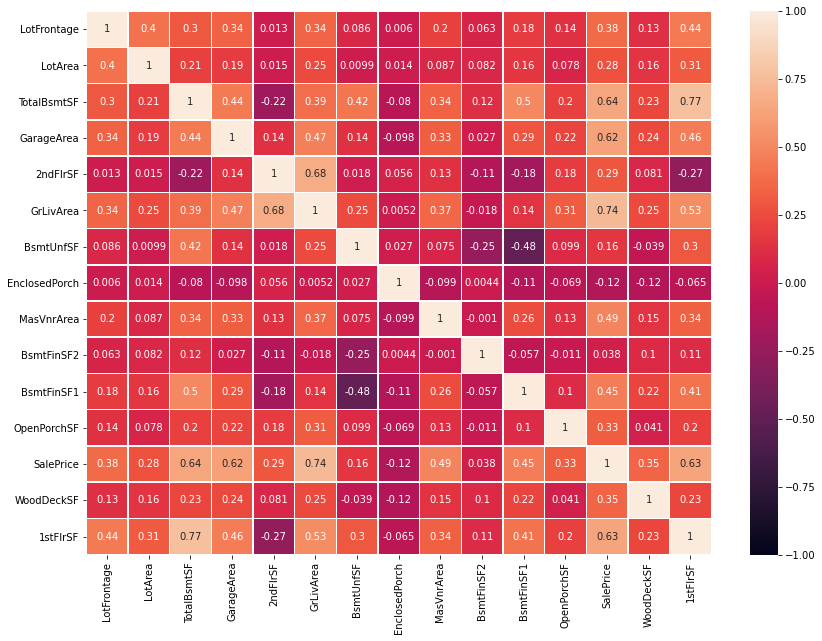

In [133]:
plt.figure(figsize=(14,10))
sns.heatmap(corr_matrix, vmin=-1, vmax=1, linewidths=.5, annot=True)

<b>Conclusion:</b> correlation between features is within reasonable values, no feature will be removed.

#### Correlation Against Target Variable (SalePrice)

In [134]:
# Remove features with low correlation (<0.01) with the target variable(SalePrice)
corr_matrix['SalePrice'].abs().sort_values(ascending=False)

SalePrice        1.000000
GrLivArea        0.736036
TotalBsmtSF      0.642354
1stFlrSF         0.634672
GarageArea       0.621900
MasVnrArea       0.486620
BsmtFinSF1       0.454087
LotFrontage      0.382420
WoodDeckSF       0.350127
OpenPorchSF      0.326489
2ndFlrSF         0.293338
LotArea          0.275066
BsmtUnfSF        0.159724
EnclosedPorch    0.117988
BsmtFinSF2       0.038346
Name: SalePrice, dtype: float64

<b>Conslusion:</b> no features will be removed since correlation between target variable and features is within reasonable values.


#### Checking for Normality: Dependent Variable

variable = y
Median: 159000.0
Mean: 175567.64318276005
Skew: 1.7453580480340125
Kurtosis: 5.825763749688768
--------------------------------------------------
variable = log10(y)
Median: 5.201397124320452
Mean: 5.244444479212366
Skew: 0.24188453291963574
Kurtosis: 0.7653528688452214


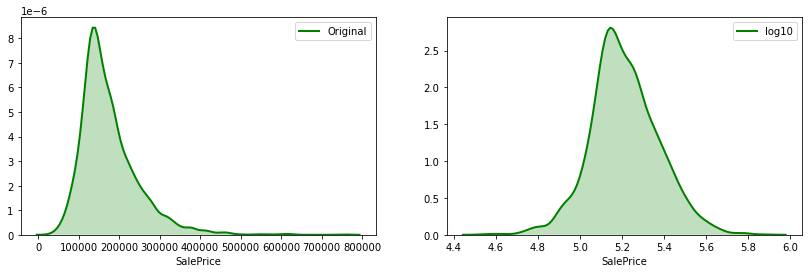

In [135]:
# Check Target variable for normal distribution
print('variable = y')
print("Median: " + str(dataset_encoded['SalePrice'].median()))
print("Mean: " + str(dataset_encoded['SalePrice'].mean()))
print("Skew: " + str(dataset_encoded['SalePrice'].skew()))
print("Kurtosis: " + str(dataset_encoded['SalePrice'].kurtosis()))
print("-"*50)
# log10
print("variable = log10(y)")
print("Median: " + str(np.log10(dataset_encoded['SalePrice'].median())))
print("Mean: " + str(np.log10(dataset_encoded['SalePrice'].mean())))
print("Skew: " + str(np.log10(dataset_encoded['SalePrice'].skew())))
print("Kurtosis: " + str(np.log10(dataset_encoded['SalePrice'].kurtosis())))
# creating axes to draw plots 
fig, ax = plt.subplots(1, 2, figsize=(14,4)) 
sns.distplot(dataset_encoded['SalePrice'], hist = False, kde = True, 
            kde_kws = {'shade': True, 'linewidth': 2},  
            label = "Original", color ="green", ax = ax[0]) 
sns.distplot(np.log10(dataset_encoded['SalePrice']), hist = False, kde = True, 
            kde_kws = {'shade': True, 'linewidth': 2},  
            label = "log10", color ="green", ax = ax[1])


<b>Conclusion:</b> Calculating the log10 of the target variable produces a distribution closer to the normal distribution.

#### Checking for Normality: Independent Variables

In [136]:
# Continuous variables -> skewness
cont_var_skew = pd.DataFrame((dataset_encoded[continuous_variables_updated]).skew().abs()).reset_index()
cont_var_log_skew = pd.DataFrame(np.log10(dataset_encoded[continuous_variables_updated]+1).skew().abs()).reset_index()
cont_var_skew.columns = ['feature','skewness']
cont_var_log_skew.columns = ['feature','skewness_log']
cont_skew = cont_var_skew.merge(cont_var_log_skew, on="feature", how="inner")
cont_skew

,feature,skewness,skewness_log
0,LotFrontage,1.137594,1.112926
1,LotArea,13.393921,0.513180
2,TotalBsmtSF,0.456386,4.948562
3,GarageArea,0.192519,3.738757
4,2ndFlrSF,0.804118,0.269066
5,GrLivArea,0.940956,0.036984
6,BsmtUnfSF,0.978891,2.129723
7,EnclosedPorch,4.096770,1.928748
8,MasVnrArea,2.750254,0.586703
9,BsmtFinSF2,3.924373,2.272369


In [137]:
# Median, Mean, Skew and Kurtosis for every continuous variable
for feature in continuous_variables_updated:
    print(feature)
    print("Median: " + str((dataset_encoded[feature]+1).median()))
    print("Mean: " + str((dataset_encoded[feature]+1).mean()))
    print("Skew: " + str((dataset_encoded[feature]+1).skew()))
    print("Kurtosis: " + str((dataset_encoded[feature]+1).kurtosis()))
    print("-"*50)

LotFrontage
Median: 71.0
Mean: 69.96187318690427
Skew: 1.137594212242333
Kurtosis: 10.048324778422657
--------------------------------------------------
LotArea
Median: 9361.0
Mean: 10061.2080397845
Skew: 13.393920620046208
Kurtosis: 270.4660677440969
--------------------------------------------------
TotalBsmtSF
Median: 971.0
Mean: 1023.8276004973062
Skew: 0.4563857964837612
Kurtosis: 1.7161185159103378
--------------------------------------------------
GarageArea
Median: 473.0
Mean: 462.2540406133444
Skew: 0.19251883526127447
Kurtosis: 0.9999532642112965
--------------------------------------------------
2ndFlrSF
Median: 1.0
Mean: 340.2428512225446
Skew: 0.804117801386001
Kurtosis: -0.5594041335096973
--------------------------------------------------
GrLivArea
Median: 1432.0
Mean: 1478.4102776626605
Skew: 0.9409557669208851
Kurtosis: 1.5380136562057776
--------------------------------------------------
BsmtUnfSF
Median: 440.0
Mean: 529.5370907583921
Skew: 0.9788912498845408
Kurtosis

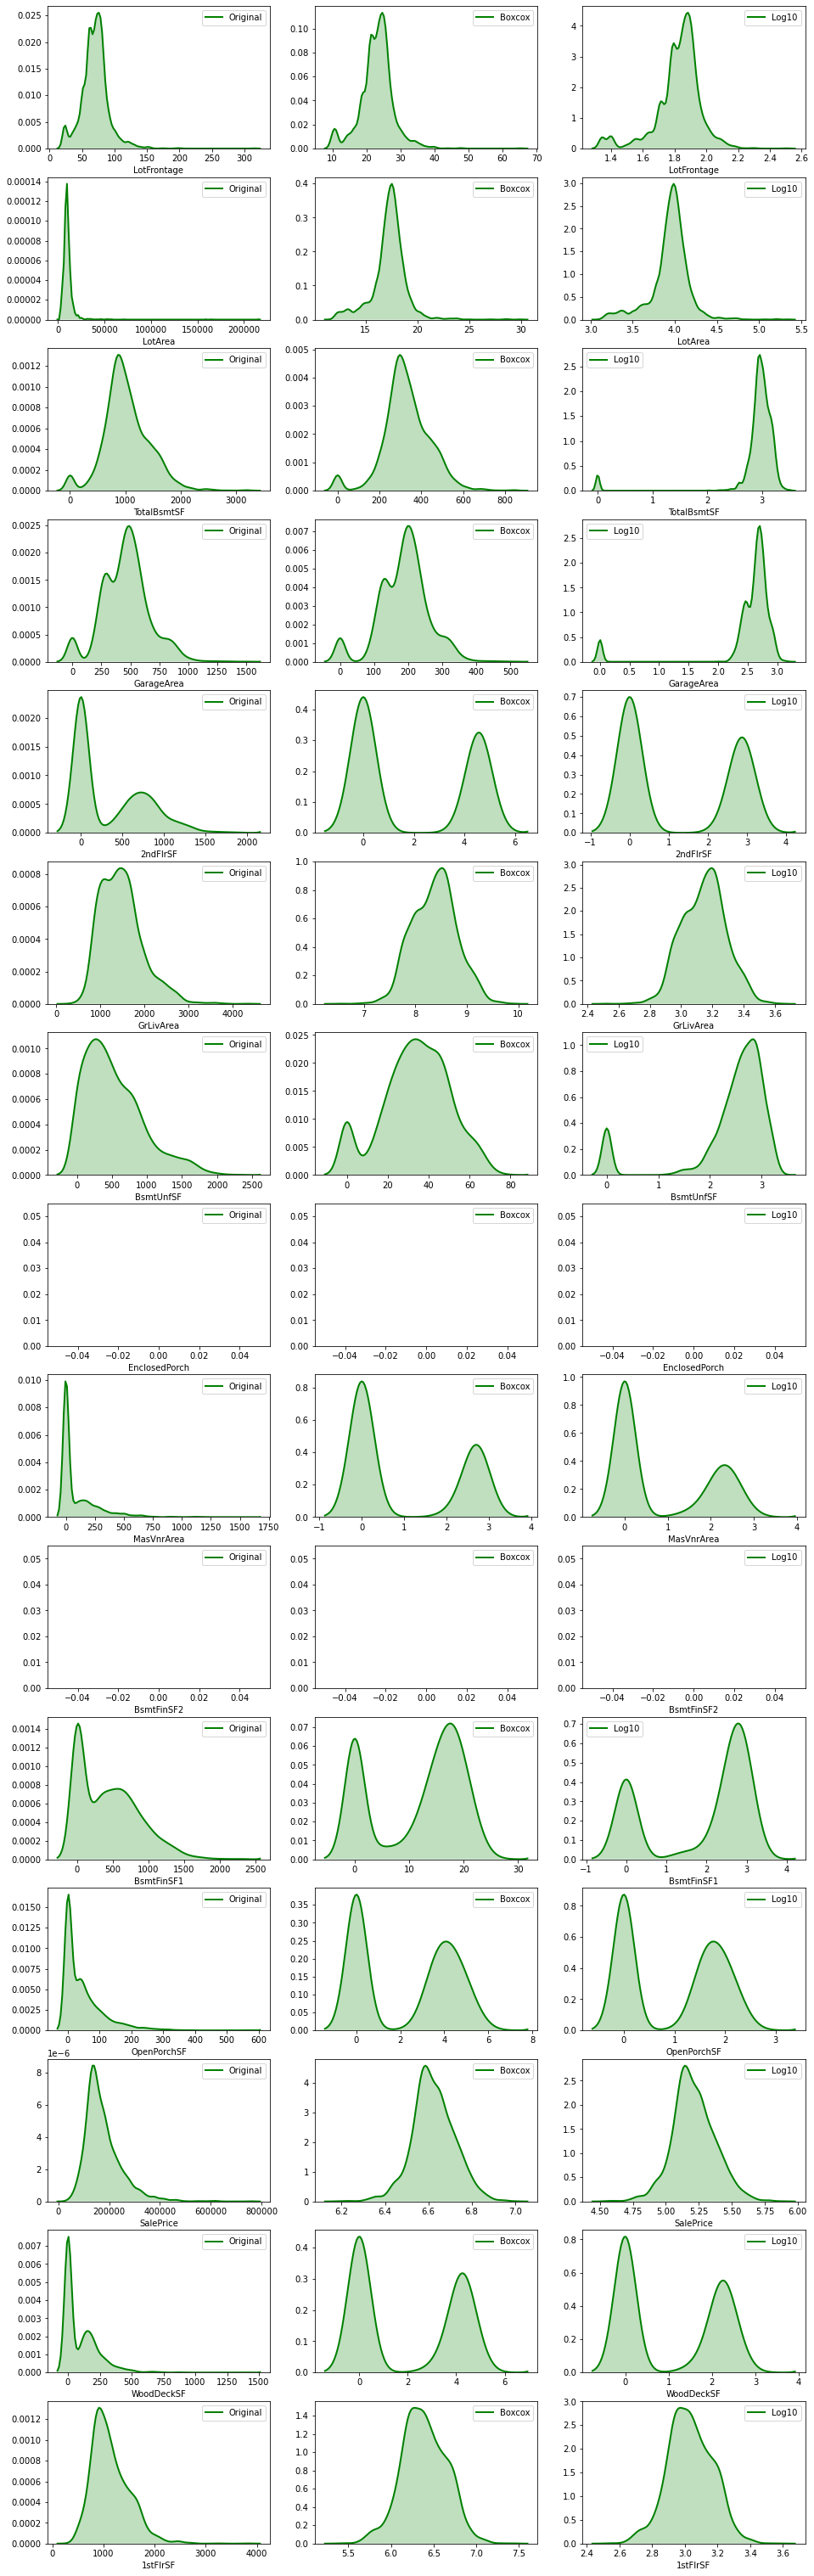

In [138]:
# creating axes to draw plots: 2 plots per feature
fig, ax = plt.subplots(dataset_encoded[continuous_variables_updated].shape[1], 3,  figsize=(16,55))

for i,feature in enumerate(continuous_variables_updated):
    original_data = dataset_encoded[feature]+1
    sns.distplot(original_data, hist = False, kde = True, 
                kde_kws = {'shade': True, 'linewidth': 2},  
                label = "Original", color ="green", ax = ax[i,0]) 

    fitted_data, fitted_lambda = stats.boxcox(original_data) 
    sns.distplot(fitted_data, hist = False, kde = True, 
                kde_kws = {'shade': True, 'linewidth': 2},  
                label = "Boxcox", color ="green", ax = ax[i,1]) 

    sns.distplot(np.log10(original_data), hist = False, kde = True, 
                kde_kws = {'shade': True, 'linewidth': 2},  
                label = "Log10", color ="green", ax = ax[i,2])

<b>Conclusion:</b> we will take the log10 of the following features: 1stFirSF, GrLivArea, and LotArea

In [218]:
dataset_encoded['log10_GrLivArea'] = np.log10(dataset_encoded['GrLivArea'])
dataset_encoded['log10_LotArea'] = np.log10(dataset_encoded['LotArea'])
dataset_encoded['log10_1stFlrSF'] = np.log10(dataset_encoded['1stFlrSF']+1)     # +1 : This means we are adding bias, but is needed for zero

<hr style="height:1px;border:none;color:#333;background-color:#333;" />

### Feature Selection

#### Using Lasso Regression to Select Features

In [219]:
dataset_encoded.drop(columns=['GrLivArea','LotArea','1stFlrSF'], inplace=True)

In [220]:
dataset_encoded

,SalePrice,LotFrontage,LotShape,Utilities,LandSlope,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,ExterQual,ExterCond,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,HeatingQC,Electrical,2ndFlrSF,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,Fence,MoSold,YrSold,BsmtNumBath,LotConfig_CulDSac,LotConfig_FR2,LotConfig_FR3,LotConfig_Inside,Neighborhood_Blueste,Neighborhood_BrDale,Neighborhood_BrkSide,Neighborhood_ClearCr,Neighborhood_CollgCr,Neighborhood_Crawfor,Neighborhood_Edwards,Neighborhood_Gilbert,Neighborhood_Greens,Neighborhood_GrnHill,Neighborhood_IDOTRR,Neighborhood_Landmrk,Neighborhood_MeadowV,Neighborhood_Mitchel,Neighborhood_NAmes,Neighborhood_NPkVill,Neighborhood_NWAmes,Neighborhood_NoRidge,Neighborhood_NridgHt,Neighborhood_OldTown,Neighborhood_SWISU,Neighborhood_Sawyer,Neighborhood_SawyerW,Neighborhood_Somerst,Neighborhood_StoneBr,Neighborhood_Timber,Neighborhood_Veenker,GarageType_Attchd,GarageType_Basment,GarageType_BuiltIn,GarageType_CarPort,GarageType_Detchd,GarageType_None,RoofMatl_Membran,RoofMatl_Metal,RoofMatl_Roll,RoofMatl_Tar&Grv,RoofMatl_WdShake,RoofMatl_WdShngl,Street_Pave,CentralAir_Y,MSZoning_C (all),MSZoning_FV,MSZoning_I (all),MSZoning_RH,MSZoning_RL,MSZoning_RM,Heating_GasA,Heating_GasW,Heating_Grav,Heating_OthW,Heating_Wall,HouseStyle_1.5Unf,HouseStyle_1Story,HouseStyle_2.5Fin,HouseStyle_2.5Unf,HouseStyle_2Story,HouseStyle_SFoyer,HouseStyle_SLvl,RoofStyle_Gable,RoofStyle_Gambrel,RoofStyle_Hip,RoofStyle_Mansard,RoofStyle_Shed,Exterior1st_AsphShn,Exterior1st_BrkComm,Exterior1st_BrkFace,Exterior1st_CBlock,Exterior1st_CemntBd,Exterior1st_HdBoard,Exterior1st_ImStucc,Exterior1st_MetalSd,Exterior1st_Plywood,Exterior1st_PreCast,Exterior1st_Stucco,Exterior1st_VinylSd,Exterior1st_Wd Sdng,Exterior1st_WdShing,Condition2_Feedr,Condition2_Norm,Condition2_PosA,Condition2_PosN,Condition2_RRAe,Condition2_RRAn,Condition2_RRNn,Foundation_CBlock,Foundation_PConc,Foundation_Slab,Foundation_Stone,Foundation_Wood,SaleType_CWD,SaleType_Con,SaleType_ConLD,SaleType_ConLI,SaleType_ConLw,SaleType_Oth,SaleType_VWD,SaleType_WD,LandContour_HLS,LandContour_Low,LandContour_Lvl,MSSubClass_30,MSSubClass_40,MSSubClass_45,MSSubClass_50,MSSubClass_60,MSSubClass_70,MSSubClass_75,MSSubClass_80,MSSubClass_85,MSSubClass_90,MSSubClass_120,MSSubClass_150,MSSubClass_160,MSSubClass_180,MSSubClass_190,BldgType_2fmCon,BldgType_Duplex,BldgType_Twnhs,BldgType_TwnhsE,MasVnrType_BrkFace,MasVnrType_None,MasVnrType_Stone,Condition1_Feedr,Condition1_Norm,Condition1_PosA,Condition1_PosN,Condition1_RRAe,Condition1_RRAn,Condition1_RRNe,Condition1_RRNn,Exterior2nd_AsphShn,Exterior2nd_Brk Cmn,Exterior2nd_BrkFace,Exterior2nd_CBlock,Exterior2nd_CmentBd,Exterior2nd_HdBoard,Exterior2nd_ImStucc,Exterior2nd_MetalSd,Exterior2nd_Plywood,Exterior2nd_PreCast,Exterior2nd_Stone,Exterior2nd_Stucco,Exterior2nd_VinylSd,Exterior2nd_Wd Sdng,Exterior2nd_Wd Shng,log10_GrLivArea,log10_LotArea,log10_1stFlrSF
0,126000,64.0,4,4,3,6,6,1939,1950,0.0,3,3,3,3,1,3,238.0,1,0.0,618.0,856.0,3,5,0,1,0,2,1,3,4,8,1,4,1939.0,1,2.0,399.0,3,3,3,0,0,0,0,3,2010,1.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,1,0,0,0,0,1,0,1,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,2.932474,3.897077,2.932981
1,139500,42.0,4,4,3,5,5,1984,1984,149.0,4,3,4,3,2,6,552.0,5,393.0,104.0,1049.0,3,5,0,2,0,2,1,4,5,8,0,0,1984.0,3,1.0,266.0,3,3,3,0,105,0,0,2,2009,1.0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,1,0,1,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,

In [83]:
X = dataset_encoded.drop('SalePrice',axis=1)  # features
y = dataset_encoded['SalePrice']              # target
X_norm = MinMaxScaler().fit_transform(X)      # Transform features by scaling each feature to a given range (0,1).

In [90]:
clf = LassoCV(alphas=np.arange(0.0001, 0.01)).fit(X_norm, y)   # set alpha low to ensure the features will have more relevance
importance = np.abs(clf.coef_)


In [91]:
# importance
clf.alpha_

0.0001

In [92]:
features =[]
scores = []
for i, feature in enumerate(X.columns):
    if importance[i]>0:
        features.append(feature)
        scores.append(importance[i])

In [93]:
feature_score = pd.DataFrame.from_dict({"feature":features,"Score":scores})

In [99]:
pd.set_option('display.max_rows', None) 
list(feature_score.sort_values(by="Score", ascending=False).head(20)['feature'])

['log10_1stFlrSF',
 'Condition2_PosA',
 '2ndFlrSF',
 'Neighborhood_GrnHill',
 'log10_LotArea',
 'BsmtFinSF1',
 'OverallQual',
 'RoofMatl_WdShngl',
 'Condition2_PosN',
 'Exterior1st_PreCast',
 'MasVnrArea',
 'log10_GrLivArea',
 'GarageType_None',
 'YearBuilt',
 'OverallCond',
 'BsmtFinSF2',
 'Heating_OthW',
 'BsmtUnfSF',
 'BsmtCond',
 'TotalBsmtSF']

<hr style="height:1px;border:none;color:#333;background-color:#333;" />

### Descriptive Modeling

#### Train and Test data

In [100]:
# Split data 70/30
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=10)

#### Multiple Linear Regression (All the variables)

In [101]:
mlr_model = LinearRegression()
mlr_model.fit(X_train,np.log(y_train))

LinearRegression()

In [102]:
# Training data
mlr_model.score(X_train,np.log(y_train))

0.9597573660025894

In [103]:
# Test data
mlr_model.score(X_test,np.log(y_test))

0.9356838157799023

In [104]:
X_train.columns.size

199

Index(['GrLivArea', 'SalePrice', 'LotFrontage', 'LotArea', 'LotShape',
       'Utilities', 'LandSlope', 'OverallQual', 'OverallCond', 'YearBuilt',
       ...
       'Exterior2nd_HdBoard', 'Exterior2nd_ImStucc', 'Exterior2nd_MetalSd',
       'Exterior2nd_Plywood', 'Exterior2nd_PreCast', 'Exterior2nd_Stone',
       'Exterior2nd_Stucco', 'Exterior2nd_VinylSd', 'Exterior2nd_Wd Sdng',
       'Exterior2nd_Wd Shng'],
      dtype='object', length=200)

In [236]:
columns_model ='Neighborhood_GrnHill + log10_LotArea +\
BsmtFinSF1 + OverallQual + \
log10_GrLivArea + GarageType_None + YearBuilt + OverallCond + BsmtFinSF2 + BsmtUnfSF + \
TotalBsmtSF' # + KitchenQual'

In [217]:
dataset_encoded

,GrLivArea,SalePrice,LotFrontage,LotArea,LotShape,Utilities,LandSlope,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,ExterQual,ExterCond,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,HeatingQC,Electrical,1stFlrSF,2ndFlrSF,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,Fence,MoSold,YrSold,BsmtNumBath,LotConfig_CulDSac,LotConfig_FR2,LotConfig_FR3,LotConfig_Inside,Neighborhood_Blueste,Neighborhood_BrDale,Neighborhood_BrkSide,Neighborhood_ClearCr,Neighborhood_CollgCr,Neighborhood_Crawfor,Neighborhood_Edwards,Neighborhood_Gilbert,Neighborhood_Greens,Neighborhood_GrnHill,Neighborhood_IDOTRR,Neighborhood_Landmrk,Neighborhood_MeadowV,Neighborhood_Mitchel,Neighborhood_NAmes,Neighborhood_NPkVill,Neighborhood_NWAmes,Neighborhood_NoRidge,Neighborhood_NridgHt,Neighborhood_OldTown,Neighborhood_SWISU,Neighborhood_Sawyer,Neighborhood_SawyerW,Neighborhood_Somerst,Neighborhood_StoneBr,Neighborhood_Timber,Neighborhood_Veenker,GarageType_Attchd,GarageType_Basment,GarageType_BuiltIn,GarageType_CarPort,GarageType_Detchd,GarageType_None,RoofMatl_Membran,RoofMatl_Metal,RoofMatl_Roll,RoofMatl_Tar&Grv,RoofMatl_WdShake,RoofMatl_WdShngl,Street_Pave,CentralAir_Y,MSZoning_C (all),MSZoning_FV,MSZoning_I (all),MSZoning_RH,MSZoning_RL,MSZoning_RM,Heating_GasA,Heating_GasW,Heating_Grav,Heating_OthW,Heating_Wall,HouseStyle_1.5Unf,HouseStyle_1Story,HouseStyle_2.5Fin,HouseStyle_2.5Unf,HouseStyle_2Story,HouseStyle_SFoyer,HouseStyle_SLvl,RoofStyle_Gable,RoofStyle_Gambrel,RoofStyle_Hip,RoofStyle_Mansard,RoofStyle_Shed,Exterior1st_AsphShn,Exterior1st_BrkComm,Exterior1st_BrkFace,Exterior1st_CBlock,Exterior1st_CemntBd,Exterior1st_HdBoard,Exterior1st_ImStucc,Exterior1st_MetalSd,Exterior1st_Plywood,Exterior1st_PreCast,Exterior1st_Stucco,Exterior1st_VinylSd,Exterior1st_Wd Sdng,Exterior1st_WdShing,Condition2_Feedr,Condition2_Norm,Condition2_PosA,Condition2_PosN,Condition2_RRAe,Condition2_RRAn,Condition2_RRNn,Foundation_CBlock,Foundation_PConc,Foundation_Slab,Foundation_Stone,Foundation_Wood,SaleType_CWD,SaleType_Con,SaleType_ConLD,SaleType_ConLI,SaleType_ConLw,SaleType_Oth,SaleType_VWD,SaleType_WD,LandContour_HLS,LandContour_Low,LandContour_Lvl,MSSubClass_30,MSSubClass_40,MSSubClass_45,MSSubClass_50,MSSubClass_60,MSSubClass_70,MSSubClass_75,MSSubClass_80,MSSubClass_85,MSSubClass_90,MSSubClass_120,MSSubClass_150,MSSubClass_160,MSSubClass_180,MSSubClass_190,BldgType_2fmCon,BldgType_Duplex,BldgType_Twnhs,BldgType_TwnhsE,MasVnrType_BrkFace,MasVnrType_None,MasVnrType_Stone,Condition1_Feedr,Condition1_Norm,Condition1_PosA,Condition1_PosN,Condition1_RRAe,Condition1_RRAn,Condition1_RRNe,Condition1_RRNn,Exterior2nd_AsphShn,Exterior2nd_Brk Cmn,Exterior2nd_BrkFace,Exterior2nd_CBlock,Exterior2nd_CmentBd,Exterior2nd_HdBoard,Exterior2nd_ImStucc,Exterior2nd_MetalSd,Exterior2nd_Plywood,Exterior2nd_PreCast,Exterior2nd_Stone,Exterior2nd_Stucco,Exterior2nd_VinylSd,Exterior2nd_Wd Sdng,Exterior2nd_Wd Shng
0,856,126000,64.0,7890,4,4,3,6,6,1939,1950,0.0,3,3,3,3,1,3,238.0,1,0.0,618.0,856.0,3,5,856,0,1,0,2,1,3,4,8,1,4,1939.0,1,2.0,399.0,3,3,3,0,0,0,0,3,2010,1.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,1,0,0,0,0,1,0,1,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
1,1049,139500,42.0,4235,4,4,3,5,5,1984,1984,149.0,4,3,4,3,2,6,552.0,5,393.0,104.0,1049.0,3,5,1049,0,2,0,2,1,4,5,8,0,0,1984.0,3,1.0,266.0,3,3,3,0,105,0,0,2,2009,1.0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,1,0,1,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,1,0

In [237]:
# Fit regression model (using the natural log of one of the regressors)
results = smf.ols('np.log10(SalePrice) ~ ' + columns_model, data=dataset_encoded).fit()

# Inspect the results
print(results.summary())

                             OLS Regression Results                            
Dep. Variable:     np.log10(SalePrice)   R-squared:                       0.914
Model:                             OLS   Adj. R-squared:                  0.913
Method:                  Least Squares   F-statistic:                     2541.
Date:                 Wed, 25 Nov 2020   Prob (F-statistic):               0.00
Time:                         18:48:41   Log-Likelihood:                 3937.5
No. Observations:                 2413   AIC:                            -7853.
Df Residuals:                     2402   BIC:                            -7789.
Df Model:                           10                                         
Covariance Type:             nonrobust                                         
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
Intercept             

<hr>

#### Linear Model with limited variables

In [ ]:
temp_col = ['Neighborhood_Blueste', 'Neighborhood_BrDale', 'Neighborhood_BrkSide','Neighborhood_ClearCr', 'Neighborhood_CollgCr', 'Neighborhood_Crawfor',
 'Neighborhood_Edwards', 'Neighborhood_Gilbert', 'Neighborhood_Greens','Neighborhood_GrnHill', 'Neighborhood_IDOTRR', 'Neighborhood_Landmrk',
 'Neighborhood_MeadowV', 'Neighborhood_Mitchel', 'Neighborhood_NAmes','Neighborhood_NPkVill', 'Neighborhood_NWAmes', 'Neighborhood_NoRidge',
 'Neighborhood_NridgHt', 'Neighborhood_OldTown', 'Neighborhood_SWISU','Neighborhood_Sawyer', 'Neighborhood_SawyerW', 'Neighborhood_Somerst',
 'Neighborhood_StoneBr', 'Neighborhood_Timber', 'Neighborhood_Veenker'] + ['GrLivArea','LotArea','OverallQual','OverallCond','TotalBsmtSF','YearBuilt',]

In [206]:
# X_train.filter(like="Neighborhood").columns.tolist()
temp_col = ['log10_1stFlrSF',
 'Condition2_PosA',
 '2ndFlrSF',
 'Neighborhood_GrnHill',
 'log10_LotArea',
 'BsmtFinSF1',
 'OverallQual',
 'RoofMatl_WdShngl',
 'Condition2_PosN',
 'Exterior1st_PreCast',
 'MasVnrArea',
 'log10_GrLivArea',
 'GarageType_None',
 'YearBuilt',
 'OverallCond',
 'BsmtFinSF2',
 'Heating_OthW',
 'BsmtUnfSF',
 'BsmtCond',
 'TotalBsmtSF']

In [106]:
# mlr_model.fit(X[temp_col], np.log10(y))
mlr_model.fit(X_train[temp_col], np.log10(y_train))
mlr_model.score(X_train[temp_col], np.log10(y_train))

0.9185558212532664

In [107]:
mlr_model.score(X_test[temp_col], np.log10(y_test))

0.9152512419125998

In [109]:
for i, name_c in enumerate(temp_col):
    print(name_c +":  " + "{:.6f}". format(mlr_model.coef_[i]))

log10_1stFlrSF:  0.226421
Condition2_PosA:  0.051881
2ndFlrSF:  0.000071
Neighborhood_GrnHill:  0.175972
log10_LotArea:  0.103796
BsmtFinSF1:  0.000039
OverallQual:  0.040396
RoofMatl_WdShngl:  0.022069
Condition2_PosN:  0.054428
Exterior1st_PreCast:  0.192419
MasVnrArea:  0.000027
log10_GrLivArea:  0.181353
GarageType_None:  -0.031871
YearBuilt:  0.001502
OverallCond:  0.021570
BsmtFinSF2:  0.000014
Heating_OthW:  -0.053328
BsmtUnfSF:  -0.000010
BsmtCond:  0.006176
TotalBsmtSF:  0.000043


In [ ]:
# y = beta0 + beta1*X1 + beta2*X2 + beta3*X3 + betaa4*X4 ...+ betan*Xn(Exterior Quality)

In [170]:
(math.exp(0.022069) - 1) * 100

2.231432172507408

<hr>

### Evaluating Overall Quality, Fence, and Roof

In [ ]:
# 'OverallQual', 'OverallCond', 'PavedDrive', 'Fence','RoofStyle', 'RoofMatl'

<h4>Roof material</h4>
<p>&nbsp;</p>
<table style="border-collapse: collapse; width: 46.0227%; height: 162px;" border="1">
<thead>
<tr style="border-style: ridge; height: 18px;">
<td style="width: 3.50375%; height: 18px;">Abbreviation</td>
<td style="width: 9.18553%; height: 18px;">Material</td>
</tr>
</thead>
<tbody>
<tr style="height: 18px;">
<td style="width: 3.50375%; height: 18px; border-style: ridge;">ClyTile</td>
<td style="width: 9.18553%; height: 18px; border-style: ridge;">Clay or Tile</td>
</tr>
<tr style="height: 18px;">
<td style="width: 3.50375%; height: 18px; border-style: ridge;">CompShg</td>
<td style="width: 9.18553%; height: 18px; border-style: ridge;">Standard (Composite) Shingle</td>
</tr>
<tr style="height: 18px;">
<td style="width: 3.50375%; height: 18px; border-style: ridge;">Membran</td>
<td style="width: 9.18553%; height: 18px; border-style: ridge;">Membrane</td>
</tr>
<tr style="height: 18px;">
<td style="width: 3.50375%; height: 18px; border-style: ridge;">Metal</td>
<td style="width: 9.18553%; height: 18px; border-style: ridge;">Metal</td>
</tr>
<tr style="height: 18px;">
<td style="width: 3.50375%; height: 18px; border-style: ridge;">Roll</td>
<td style="width: 9.18553%; height: 18px; border-style: ridge;">Roll</td>
</tr>
<tr style="height: 18px;">
<td style="width: 3.50375%; height: 18px; border-style: ridge;">Tar&amp;Grv</td>
<td style="width: 9.18553%; height: 18px; border-style: ridge;">Gravel &amp; Tar</td>
</tr>
<tr style="height: 18px;">
<td style="width: 3.50375%; height: 18px; border-style: ridge;">WdShake</td>
<td style="width: 9.18553%; height: 18px; border-style: ridge;">Wood Shakes</td>
</tr>
<tr style="height: 18px;">
<td style="width: 3.50375%; height: 18px; border-style: ridge;">WdShngl</td>
<td style="width: 9.18553%; height: 18px; border-style: ridge;">Wood Shingles</td>
</tr>
</tbody>
</table>

In [177]:
# dataset['CostSquareFoot'] = dataset['SalePrice'] / dataset['GrLivArea']
dataset.groupby('RoofMatl').agg({'SalePrice':"mean", "GrLivArea":"mean", "CostSquareFoot":"mean"}).sort_values(by="SalePrice", ascending=False)

,SalePrice,GrLivArea,CostSquareFoot
RoofMatl,,,
WdShngl,374357.142857,2416.571429,156.181288
WdShake,241714.285714,2163.571429,116.466386
Membran,241500.000000,1363.000000,177.182685
Tar&Grv,191700.000000,1602.666667,122.708984
Metal,180000.000000,988.000000,182.186235
CompShg,174673.760185,1471.910542,120.060648
Roll,137000.000000,1920.000000,71.354167


In [186]:
dataset[dataset['RoofMatl']=="WdShake"]

,GrLivArea,SalePrice,MSSubClass,MSZoning,LotFrontage,LotArea,Street,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,Fence,MoSold,YrSold,SaleType,BsmtNumBath,CostSquareFoot
220,1969,190000,60,RL,92.0,11952,Pave,4,Lvl,4,Inside,3,NWAmes,PosA,Norm,1Fam,2Story,7,6,1977,1977,Mansard,WdShake,WdShing,Plywood,None,0.0,3,3,CBlock,4,3,1,1,0.0,1,0.0,808.0,808.0,GasA,3,Y,5,1161,808,2,1,3,1,3,8,8,1,4,Attchd,1977.0,2,2.0,534.0,3,3,3,0,0,0,0,11,2007,WD,0.0,96.495683
1222,1930,192000,60,RL,61.0,11339,Pave,3,Lvl,4,Inside,3,NWAmes,PosA,Norm,1Fam,2Story,7,5,1979,1979,Hip,WdShake,HdBoard,Plywood,BrkFace,549.0,3,3,CBlock,4,3,1,5,758.0,1,0.0,22.0,780.0,GasA,3,Y,5,1085,845,2,1,4,1,4,9,8,1,3,Attchd,1979.0,3,2.0,481.0,3,3,3,192,72,0,0,3,2007,WD,1.0,99.481865
1586,2840,292500,60,RL,80.0,12511,Pave,3,Lvl,4,Corner,3,NWAmes,Norm,Norm,1Fam,2Story,7,7,1978,1978,Mansard,WdShake,Plywood,Plywood,BrkFace,168.0,4,3,PConc,4,3,1,5,988.0,1,0.0,432.0,1420.0,GasA,5,Y,5,1420,1420,2,1,4,1,4,8,6,2,4,Attchd,1978.0,3,4.0,1314.0,3,4,3,0,16,0,3,12,2008,WD,0.5,102.992958
1959,1524,260000,40,RL,89.0,23595,Pave,4,Low,4,Inside,1,ClearCr,Norm,Norm,1Fam,1Story,7,6,1979,1979,Shed,WdShake,Plywood,Plywood,None,0.0,4,3,PConc,4,3,4,6,1258.0,1,0.0,74.0,1332.0,GasA,3,Y,5,1332,192,0,1,0,1,4,4,8,1,3,Attchd,1979.0,3,2.0,586.0,3,3,3,268,0,0,0,4,2010,WD,2.0,170.603675
2147,2197,287500,60,RL,91.0,10010,Pave,4,Lvl,4,Inside,3,NoRidge,Norm,Norm,1Fam,2Story,7,5,1993,1994,Hip,WdShake,VinylSd,VinylSd,BrkFace,320.0,4,3,PConc,4,3,3,4,228.0,6,852.0,0.0,1080.0,GasA,5,Y,5,1108,1089,2,1,4,1,4,9,8,1,4,Attchd,1993.0,3,3.0,783.0,3,3,3,385,99,0,0,7,2008,WD,1.0,130.860264
2397,2978,242000,80,RL,96.0,11275,Pave,4,Lvl,4,Corner,3,NAmes,PosN,Norm,1Fam,SLvl,7,7,1967,2007,Mansard,WdShake,Wd Sdng,Wd Sdng,BrkFace,300.0,4,4,CBlock,4,3,1,1,0.0,1,0.0,710.0,710.0,GasA,5,Y,5,1898,1080,2,1,5,1,4,11,8,1,4,BuiltIn,1967.0,3,2.0,564.0,3,3,3,240,0,0,0,6,2010,WD,0.0,81.262592
2502,1707,228000,20,RL,80.0,16669,Pave,3,Lvl,4,Corner,3,Timber,Norm,Norm,1Fam,1Story,8,6,1981,1981,Hip,WdShake,Plywood,Plywood,BrkFace,653.0,4,3,CBlock,4,3,1,1,0.0,1,0.0,1686.0,1686.0,GasA,3,Y,5,1707,0,2,1,2,1,3,6,8,1,3,Attchd,1981.0,2,2.0,511.0,3,3,3,574,64,0,0,1,2006,WD,0.0,133.567663


In [ ]:
RoofMatl_Membran:
RoofMatl_Metal:
RoofMatl_Roll:
RoofMatl_Tar&Grv:
RoofMatl_WdShake:
RoofMatl_WdShngl:

In [172]:
temp_col = X_train.filter(like="RoofMatl").columns.tolist() + ['log10_1stFlrSF',
 'Condition2_PosA',
 '2ndFlrSF',
 'Neighborhood_GrnHill',
 'log10_LotArea',
 'BsmtFinSF1',
 'OverallQual',
 # 'RoofMatl_WdShngl',
 'Condition2_PosN',
 'Exterior1st_PreCast',
 'MasVnrArea',
 'log10_GrLivArea',
 'GarageType_None',
 'YearBuilt',
 'OverallCond',
 'BsmtFinSF2',
 'Heating_OthW',
 'BsmtUnfSF',
 'BsmtCond',
 'TotalBsmtSF']

In [173]:
# mlr_model.fit(X[temp_col], np.log10(y))
mlr_model.fit(X_train[temp_col], np.log10(y_train))
mlr_model.score(X_train[temp_col], np.log10(y_train))

0.9190136940431833

In [196]:
(10**(0.023188) - 1) * 100 #-> 5%

5.484342451982416

In [ ]:
# Try Statmodels to create MLR and calculate p-values
# Run model to predict house price and switch root material to see the difference...

In [174]:
for i, name_c in enumerate(temp_col):
    print(name_c +":  " + "{:.6f}". format(mlr_model.coef_[i]))

RoofMatl_Membran:  0.037038
RoofMatl_Metal:  0.058420
RoofMatl_Roll:  0.000000
RoofMatl_Tar&Grv:  0.038608
RoofMatl_WdShake:  -0.020908
RoofMatl_WdShngl:  0.023188
log10_1stFlrSF:  0.228772
Condition2_PosA:  0.051650
2ndFlrSF:  0.000072
Neighborhood_GrnHill:  0.176347
log10_LotArea:  0.102712
BsmtFinSF1:  0.000039
OverallQual:  0.040461
Condition2_PosN:  0.054719
Exterior1st_PreCast:  0.155333
MasVnrArea:  0.000027
log10_GrLivArea:  0.178372
GarageType_None:  -0.032711
YearBuilt:  0.001504
OverallCond:  0.021699
BsmtFinSF2:  0.000013
Heating_OthW:  -0.052556
BsmtUnfSF:  -0.000009
BsmtCond:  0.006296
TotalBsmtSF:  0.000042


#### Linear Model

<b>Ava: </b>'BsmtQual', 'BsmtCond','BsmtFinType1', 'BsmtFinType1', 'BsmtUnfSF', 'TotalBsmtSF'

<b>Khamanna: </b>'ExterCond', 'ExterQual', 'Exterior1st', 'Exterior2nd', 'MasVnrType', 'MasVnrArea', 'GarageFinish', GarageQual', 'GarageCond',

<b>Ariel:</b>'OverallQual', 'OverallCond', 'PavedDrive', 'Fence', 'RoofStyle', 'RoofMatl',

<b>Shay: </b>'HeatingQC', 'CentralAir', 'KitchenAbvGr', 'KitchenQual', 'Fireplaces', 'FireplaceQu', 'LowQualFinSF'
 
y = beta0 + beta1*X1 + beta2*X2 + beta3*X3 + beta4*X4 ...+ betan*Xn(Exterior Quality)

1) Garage -> 'GarageFinish', 'GarageQual', 'GarageCond'
2) Exterior -> 'ExterCond', 'ExterQual', 'Exterior1st', 'Exterior2nd'

1) Basement -> 'BsmtQual', 'BsmtCond','BsmtFinType1', 'BsmtFinType1', 'BsmtUnfSF', 'TotalBsmtSF'
2) 'Fireplaces', 'FireplaceQu', 

1) Overall Condition -> 'OverallQual', 'OverallCond',
2) RoofStyle, RoofMatl

1) AC -> 'HeatingQC', 'CentralAir'
2) 'KitchenAbvGr', 'KitchenQual'
3) 'LowQualFinSF'

In [197]:
dataset[dataset['RoofMatl']=="WdShngl"]

,GrLivArea,SalePrice,MSSubClass,MSZoning,LotFrontage,LotArea,Street,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,Fence,MoSold,YrSold,SaleType,BsmtNumBath,CostSquareFoot
347,1842,385000,20,RL,68.0,50271,Pave,3,Low,4,Inside,3,Veenker,Norm,Norm,1Fam,1Story,9,5,1981,1987,Gable,WdShngl,WdShing,Wd Shng,None,0.0,4,3,CBlock,5,3,4,6,1810.0,1,0.0,32.0,1842.0,GasA,4,Y,5,1842,0,0,1,0,1,4,5,8,1,4,Attchd,1981.0,3,3.0,894.0,3,3,3,857,72,0,0,11,2006,WD,2.0,209.011944
538,2524,278000,20,RL,80.0,9600,Pave,4,Lvl,4,Inside,3,NWAmes,PosN,Norm,1Fam,1Story,8,5,1981,1981,Hip,WdShngl,BrkFace,BrkFace,None,0.0,4,3,PConc,4,3,1,5,1104.0,1,0.0,1420.0,2524.0,GasA,3,Y,5,2524,0,2,1,4,1,4,9,8,1,4,Attchd,1981.0,3,2.0,542.0,3,3,3,474,120,0,3,7,2009,WD,1.0,110.142631
1007,4316,755000,60,RL,104.0,21535,Pave,3,Lvl,4,Corner,3,NoRidge,Norm,Norm,1Fam,2Story,10,6,1994,1995,Gable,WdShngl,HdBoard,HdBoard,BrkFace,1170.0,5,3,PConc,5,3,4,6,1455.0,1,0.0,989.0,2444.0,GasA,5,Y,5,2444,1872,3,1,4,1,5,10,8,2,5,Attchd,1994.0,3,3.0,832.0,3,3,3,382,50,0,0,1,2007,WD,0.5,174.930491
1626,1743,279000,20,RL,155.0,20064,Pave,3,Low,4,Inside,1,ClearCr,Norm,Norm,1Fam,1Story,8,6,1976,1976,Shed,WdShngl,Wd Sdng,Wd Sdng,None,0.0,4,3,CBlock,4,4,4,2,51.0,6,915.0,0.0,966.0,GasA,5,Y,5,1743,0,0,1,0,1,4,5,8,2,2,Attchd,1976.0,3,2.0,529.0,3,3,3,646,0,0,0,5,2007,WD,2.0,160.068847
1954,1533,280000,20,RL,62.0,70761,Pave,3,Low,4,Inside,2,ClearCr,Norm,Norm,1Fam,1Story,7,5,1975,1975,Gable,WdShngl,Plywood,Plywood,None,0.0,3,3,CBlock,4,3,4,5,655.0,1,0.0,878.0,1533.0,GasA,3,Y,5,1533,0,2,0,2,1,4,5,8,2,3,Attchd,1975.0,1,2.0,576.0,3,3,3,200,54,0,0,12,2006,WD,1.0,182.648402
2003,3608,475000,75,RM,90.0,22950,Pave,2,Lvl,4,Inside,3,OldTown,Artery,Norm,1Fam,2.5Fin,10,9,1892,1993,Gable,WdShngl,Wd Sdng,Wd Sdng,None,0.0,4,4,BrkTil,3,3,2,1,0.0,1,0.0,1107.0,1107.0,GasA,5,Y,5,1518,1518,2,1,4,1,5,12,8,2,3,Detchd,1993.0,1,3.0,840.0,5,3,3,0,260,0,4,6,2006,WD,0.0,131.651885
2190,1350,168500,80,RL,82.0,9020,Pave,4,Lvl,4,Corner,3,NAmes,Feedr,Norm,1Fam,SLvl,6,5,1964,1964,Gable,WdShngl,Plywood,Wd Sdng,BrkFace,259.0,3,3,CBlock,3,3,4,6,624.0,3,336.0,288.0,1248.0,GasA,3,Y,5,1350,0,1,1,3,1,3,6,8,0,0,Attchd,1964.0,2,2.0,520.0,3,3,3,176,0,0,4,6,2008,WD,1.0,124.814815
